Abstractive Text Summarization
===
This notebook is an in-progress implementation of the [Abstractive Text Summarization using Sequence-to-sequence RNNs and
Beyond](https://arxiv.org/abs/1602.06023) paper.

Current Features
---
* model architecture supports LSTM & GRU (biLSTM-to-uniLSTM or biGRU-to-uniGRU)
* implements batch data processing 
* implements attention mechanism ([Bahdanau et al.](https://arxiv.org/abs/1409.0473) & [Luong et al.(global dot)](https://arxiv.org/abs/1508.04025))
* implements [scheduled sampling (teacher forcing)](https://arxiv.org/abs/1506.03099)
* implements [tied embeddings](https://arxiv.org/pdf/1608.05859.pdf)
* initializes encoder-decoder with pretrained vectors (glove.6B.200d)
* implements custom training callbacks (tensorboard visualization for PyTorch, save best model & log checkpoint)
* implements attention plots


To-Do
---
* Implement additional linguistic features embeddings  
* Implement generator-pointer switch and replace unknown words by selecting source token with the highest attention score.
* Implement large vocabulary trick 
* Implement sentence level attention 
* Implement beam search during inference
* implement rouge eevaluation

Requirements
---

1. Create conda environment 

`conda env create -f environment.yml`  --gpu

`conda env create -f environment-cpu.yml`  --cpu

2. Install dependencies (PyTorch, Fastai, TorchText, Tensorboard etc) via:

`pip install -r requirements.txt`

3. Download `spacy` english module

`python -m spacy download en`


Dataset
--

The dataset used is a subset of the gigaword dataset and can be found [here](https://drive.google.com/file/d/0B6N7tANPyVeBNmlSX19Ld2xDU1E/view?usp=sharing).

It contains 3,803,955 parallel source & target examples for training and 189,649 examples for validation.

After downloading, we create article-title pairs, save in tabular datset format (.csv) and extract a sample subset (80,000 for training & 20,000 for validation). This data preparation can be found [here](/data-preparation.ipynb).

An example article-title pair looks like this:

`article: the algerian cabinet chaired by president abdelaziz bouteflika on sunday adopted the #### finance bill predicated on an oil price of ## dollars a barrel and a growth rate of #.# percent , it was announced here .`

`title: algeria adopts #### finance bill with oil put at ## dollars a barrel`


Training on the complete dataset (3M) would take a really long time. So in order to train and experiment faster we use our sample subset of 80,000 in this tutorial. 

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#declare the directory path to dataset  
DATA_PATH = 'data/'
SAMPLE_DATA_PATH = f'{DATA_PATH}sample_data/'
PROCESSED_DATA_PATH = f'{DATA_PATH}processed_data/'

#Enable GPU training 
import torch
USE_GPU = torch.cuda.is_available()
print('USE_GPU={}'.format(USE_GPU))
if USE_GPU:
    print('current_device={}'.format(torch.cuda.current_device()))

USE_GPU=False


## 1. Process dataset

In order to train, we performed common processing steps on the dataset such as:

* Loading dataset
* Preprocessing dataset (tokenizing, appending begining-of-sentence and end-of-sentence tokens, truncating, etc)
* Building a vocabulary
* Creating dataset iterators
* Batching, padding, and numericalizing. 

To process the dataset, we use the [torchtext](https://github.com/pytorch/text) library.

In [3]:
#import data, vocab from torchtext 
from torchtext import data, vocab

### 1.1. Load & define preprocessing pipeline

To pre-process our data, we declare a `Field` class, and pass additional pre-processing arguments ( ex. tokenize with the `spacy` tokenizer, `lower` and append an `end-of-sentence` token to every example ).

In [4]:
tokenizer = data.get_tokenizer('spacy')

In [4]:
TEXT = data.Field(tokenize=tokenizer, lower=True, eos_token='_eos_')

Next, we load our training & validation tabular dataset using `data.TabularDataset.splits` which applies the defined preprocessing pipeline and returns their respective `Dataset` objects

In [5]:
%%time
trn_data_fields = [("source", TEXT),
                   ("target", TEXT)]

trn, vld = data.TabularDataset.splits(path=f'{SAMPLE_DATA_PATH}',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=trn_data_fields)


CPU times: user 98.2 ms, sys: 2.39 ms, total: 101 ms
Wall time: 104 ms


In [341]:
# a sample of the preprocessed data
print(trn[0].article, trn[0].title)

['the', 'second', 'day', 'of', 'negotiations', 'on', 'power', '-', 'sharing', 'in', 'zimbabwe', 'ended', 'wednesday', 'without', 'a', 'deal', ',', 'but', 'president', 'robert', 'mugabe', 'said', 'participants', 'will', '``', 'hopefully', "''", 'reach', 'an', 'accord', 'thursday', '.'] ['no', 'deal', 'yet', 'but', 'mugabe', 'hopes', 'for', 'zimbabwe', 'deal', 'thursday']


### 1.2. Build vocabulary

Building a vocabulary simply means mapping each unique token in the corpus to an integer value, and storing as a dictionary ex `{'the': 2, 'brown':3, 'fox':4}`. 

In addition to building a vocabulary, we also use torchtext to load an embedding matrix for each token using the `glove.6B.200d` pretrained vector.

We pass to `TEXT.build_vocab` our training dataset object `trn` and also the name of the pretrained vector we would like to use `glove.6B.200d`

In [7]:
%%time
pretrained_vectors = 'glove.6B.200d' 
TEXT.build_vocab(trn, vectors=pretrained_vectors )

CPU times: user 1.08 s, sys: 4.08 s, total: 5.16 s
Wall time: 5.84 s


In [342]:
#10 most frequent words in the vocab
TEXT.vocab.freqs.most_common(10)

[('the', 92),
 ('#', 92),
 ('.', 86),
 ('in', 67),
 ('of', 56),
 (',', 56),
 ('a', 53),
 ('to', 45),
 ('on', 41),
 ('and', 39)]

### 1.3. Create dataset iterator, batch, pad, and numericalize. 


Next, create a training & validation iterator object, numericalize (turn text to tensors), batch examples of similar lengths together, randomly shuffle the data and pad tensors using `data.BucketIterator.splits`. 

In [ ]:
batch_size = 64

In [243]:
train_iter, val_iter = data.BucketIterator.splits(
                        (trn, vld), batch_sizes=(batch_size, int(batch_size*1.6)),
                        device=(0 if USE_GPU else -1), 
                        sort_key=lambda x: len(x.source),
                        shuffle=True, sort_within_batch=False, repeat=False)

Next, we stick each article-title batch pair tensor into a tuple (article, title). To do this we create a custom helper class `BatchTuple`

In [244]:
class BatchTuple():
    def __init__(self, dataset, x_var, y_var):
        self.dataset, self.x_var, self.y_var = dataset, x_var, y_var
        
    def __iter__(self):
        for batch in self.dataset:
            x = getattr(batch, self.x_var) 
            y = getattr(batch, self.y_var)                 
            yield (x, y)
            
    def __len__(self):
        return len(self.dataset)

In [245]:
#returns tuple of article-title pair tensors
train_iter_tuple = BatchTuple(train_iter, "source", "target")
val_iter_tuple = BatchTuple(val_iter, "source", "target")

In [345]:
#an example of a batched and padded article-title tensor pair
next(iter(train_iter_tuple))

(tensor([[  55,    4,   96,  ...,    4,  218,    4],
         [  42,  122,   37,  ...,  696,   15,   14],
         [  15,  118,   47,  ...,   21,  339,   64],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 tensor([[  55,   14,   96,  ...,  323,  339,   14],
         [  42,   19,   84,  ...,  223,  229,  748],
         [  15,  231,   30,  ...,   21,  223,  228],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]))

### 1.4. Create ModelData 

In order to use our batched dataset with the FastAI library, we create a `ModelData` object. 

`ModelData` simply sticks the training, validation (and test) dataset into a single object

In [247]:
#import text module from fastai 
from fastai.text import *

In [248]:
model_data = ModelData(DATA_PATH, trn_dl=train_iter_tuple, val_dl=val_iter_tuple)

### 1.5. Processed dataset

Finally, we are done with processing the dataset: pre-processing, numericalizing, batching and padding.

Lets take a look at the final processed data 

In [296]:
#number of batches in training & validation set and number of tokens in vocabulary
len(model_data.trn_dl), len(model_data.val_dl), len(TEXT.vocab)

(1, 1, 890)

In [297]:
#shape of one batch in training set (sequence_length x batch_size)
t, z = next(model_data.trn_dl.__iter__())
t.size(), z.size()

(torch.Size([45, 64]), torch.Size([18, 64]))

In [298]:
#lets look at an example pair
sample_source = t.transpose(1,0)[0].data.cpu().numpy()
sample_target = z.transpose(1,0)[0].data.cpu().numpy()

print("source:\n%s \n\ncorresponding tensor:\n%s \n" %(' '.join([TEXT.vocab.itos[o] for o in sample_article]), sample_source))
print("target:\n%s \n\ncorresponding tensor:\n%s \n" %(' '.join([TEXT.vocab.itos[o] for o in sample_title]), sample_target))


article:
bolivian president evo morales on wednesday declared the us ambassador to la paz `` persona non grata , '' accusing the envoy of encouraging the breakup of the country by promoting separatism . _eos_ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

corresponding tensor:
[216  28 153 167  11  13 145   4  14  57  10 294 328  20 329 316 269   7  23 130   4  50   8 254   4 217   8
   4  48  24 341 353   5   2   1   1   1   1   1   1   1   1   1   1   1] 

title:
bolivia president orders us envoy expelled _eos_ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

corresponding tensor:
[ 58  28 171  14  50 154   2   1   1   1   1   1   1   1   1   1   1   1] 



## 2. Model 

### 2.1. Define model architecture
The sequence model, consists of:
* single layer encoder-decoder RNNs (biGRU-to-uniGRU)
* feed-forward attention network (bahdanau)
* option for luong global dot attention
* option for teacher forcing
* option for tied embeddings
* option for multi-layer model
* option for regularization (dropout)

In [374]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class Seq2SeqRNN(nn.Module):
    
    def __init__(self, rnn_type, input_size, embz_size, hidden_size, batch_size,output_size,max_tgt_len,
                 attention_type, tied_weight_type, pre_trained_vector, pre_trained_vector_type, padding_idx,
                 num_layers=1, encoder_drop=(0.0,0.0), decoder_drop=(0.0,0.0), 
                 bidirectional=True, bias=False, teacher_forcing=True):
        
        super().__init__()
        
        rnn_type, attention_type, tied_weight_type = rnn_type.upper(), attention_type.title(), tied_weight_type.lower()
        
        if rnn_type in ['LSTM', 'GRU']: self.rnn_type = rnn_type
        else: raise ValueError("""An invalid option for '--rnn_type' was supplied,
                                    options are ['LSTM', 'GRU']""")
            
        if attention_type in ['Luong', 'Bahdanau']: self.attention_type = attention_type
        else: raise ValueError("""An invalid option for '--attention_type' was supplied,
                                    options are ['Luong', 'Bahdanau']""")
            
        if tied_weight_type in ['three_way', 'two_way']: self.tied_weight_type = tied_weight_type
        else: raise ValueError("""An invalid option for '--tied_weight_type' was supplied,
                                    options are ['three_way', 'two_way']""")
    
                    
        #initialize model parameters            
        self.output_size, self.embz_size, self.hidden_size = output_size, embz_size, hidden_size//2
        self.num_layers, self.input_size, self.max_tgt_len, self.pre_trained_vector = num_layers, input_size, max_tgt_len, pre_trained_vector
        self.bidirectional,self.teacher_forcing, self.pre_trained_vector_type = bidirectional, teacher_forcing, pre_trained_vector_type
        self.encoder_drop, self.decoder_drop, self.padding_idx = encoder_drop, decoder_drop, padding_idx
        
        
        if self.teacher_forcing: self.force_prob = 1.0
        
        #set bidirectional
        if self.bidirectional: self.num_directions = 2
        else: self.num_directions = 1
            
        
        #encoder
        self.encoder_dropout = nn.Dropout(self.encoder_drop[0])
        self.encoder_embedding_layer = nn.Embedding(self.input_size, self.embz_size, padding_idx=self.padding_idx)
        if self.pre_trained_vector: self.encoder_embedding_layer.weight.data.copy_(self.pre_trained_vector.weight.data)
            
        self.encoder_rnn = getattr(nn, self.rnn_type)(
                           input_size=self.embz_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.encoder_drop[1], 
                           bidirectional=self.bidirectional)
        self.encoder_vector_layer = nn.Linear(self.hidden_size*self.num_directions,self.embz_size, bias=bias)
        
       #decoder
        self.decoder_dropout = nn.Dropout(self.decoder_drop[0])
        self.decoder_embedding_layer = nn.Embedding(self.input_size, self.embz_size, padding_idx=self.padding_idx)
        self.decoder_rnn = getattr(nn, self.rnn_type)(
                           input_size=self.embz_size,
                           hidden_size=self.hidden_size*self.num_directions,
                           num_layers=self.num_layers,
                           dropout=self.decoder_drop[1]) 
        self.decoder_output_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
        self.output_layer = nn.Linear(self.embz_size, self.output_size, bias=bias)
        
        #set tied weights: three way tied weights vs two way tied weights
        if self.tied_weight_type == 'three_way':
            self.decoder_embedding_layer.weight  = self.encoder_embedding_layer.weight
            self.output_layer.weight = self.decoder_embedding_layer.weight  
        else:
            if self.pre_trained_vector: self.decoder_embedding_layer.weight.data.copy_(self.pre_trained_vector.weight.data)
            self.output_layer.weight = self.decoder_embedding_layer.weight  
            
        #set attention
        self.encoder_output_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
        self.att_vector_layer = nn.Linear(self.embz_size+self.embz_size, self.embz_size,bias=bias)
        if self.attention_type == 'Bahdanau':
            self.decoder_hidden_layer = nn.Linear(self.hidden_size*self.num_directions, self.embz_size, bias=bias)
            self.att_score = nn.Linear(self.embz_size,1,bias=bias)

            
    
    def init_hidden(self, batch_size):
        if self.rnn_type == 'LSTM':
            return (V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)),
                    V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)))
        else:
            return V(torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size))
   

    def _cat_directions(self, hidden):
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
        return hidden    
    
    
    def bahdanau_attention(self, encoder_output, decoder_hidden, decoder_input):
        encoder_output = self.encoder_output_layer(encoder_output) 
        encoder_output = encoder_output.transpose(0,1)
        decoder_hidden = decoder_hidden.transpose(0,1)
        att_score = F.tanh(encoder_output + decoder_hidden)
        att_score = self.att_score(att_score)
        att_weight = F.softmax(att_score, dim=1)
        context_vector = torch.bmm(att_weight.transpose(-1, 1), encoder_output).squeeze(1)
        att_vector = torch.cat((context_vector, decoder_input), dim=1)
        att_vector = self.att_vector_layer(att_vector)
        return att_weight.squeeze(-1), att_vector
    
    
    def luong_attention(self, encoder_output, decoder_output):
        encoder_output = self.encoder_output_layer(encoder_output) 
        encoder_output = encoder_output.transpose(0,1)
        decoder_output = decoder_output.transpose(0,1)
        att_score = torch.bmm(encoder_output, decoder_output.transpose(-1,1))
        att_weight = F.softmax(att_score, dim=1)
        context_vector = torch.bmm(att_weight.transpose(-1, 1), encoder_output).squeeze(1)
        att_vector = torch.cat((context_vector, decoder_output.squeeze(1)), dim=1)
        att_vector = self.att_vector_layer(att_vector)
        att_vector = F.tanh(att_vector)
        return att_weight.squeeze(-1), att_vector
        
    def decoder_forward(self, batch_size, encoder_output, decoder_hidden, y=None):
        decoder_input = V(torch.zeros(batch_size).long())  
        output_seq_stack, att_stack = [], []
        
        for i in range(self.max_tgt_len):
            decoder_input = self.decoder_dropout(self.decoder_embedding_layer(decoder_input))
            if self.attention_type == 'Bahdanau':
                if isinstance(decoder_hidden, tuple):
                    prev_hidden = self.decoder_hidden_layer(decoder_hidden[0][-1]).unsqueeze(0)
                else:
                    prev_hidden = self.decoder_hidden_layer(decoder_hidden[-1]).unsqueeze(0) 
                att, decoder_input = self.bahdanau_attention(encoder_output, prev_hidden, decoder_input)
                decoder_output, decoder_hidden = self.decoder_rnn(decoder_input.unsqueeze(0), decoder_hidden)
                decoder_output = self.decoder_output_layer(decoder_output.squeeze(0)) 
            else:
                decoder_output, decoder_hidden = self.decoder_rnn(decoder_input.unsqueeze(0), decoder_hidden)
                decoder_output = self.decoder_output_layer(decoder_output) 
                att, decoder_output = self.luong_attention(encoder_output, decoder_output)
            att_stack.append(att)
            output = self.output_layer(decoder_output)
            output_seq_stack.append(output)
            decoder_input = V(output.data.max(1)[1])
            if (decoder_input==1).all(): break 
            if self.teacher_forcing:    
                samp_prob = round(random.random(),1)
                if (y is not None) and (samp_prob < self.force_prob):
                    if i >= len(y): break
                    decoder_input = y[i] 
                
        return torch.stack(output_seq_stack), torch.stack(att_stack)
        
                
    def forward(self, seq, y=None):
        batch_size = seq[0].size(0)
        encoder_hidden = self.init_hidden(batch_size)
        encoder_input = self.encoder_dropout(self.encoder_embedding_layer(seq))
        encoder_output, encoder_hidden = self.encoder_rnn(encoder_input, encoder_hidden) 
        if self.bidirectional:
            encoder_hidden = self._cat_directions(encoder_hidden)
        output = self.decoder_forward(batch_size, encoder_output, encoder_hidden, y=y)
        if isinstance(encoder_hidden, tuple):
            encoder_vector = self.encoder_vector_layer(encoder_hidden[0][-1])
        else:
            encoder_vector = self.encoder_vector_layer(encoder_hidden[-1])
        output = output + (encoder_vector,)  
        return output
    


In [ ]:
#set maximum target summary size 
its = [next(model_data.trn_dl.__iter__())[1] for i in range(10)]
max_tgt_len = int(np.percentile([its[o].size()[0] for o in range(len(its))], 99))
max_tgt_len

In [ ]:
rev=0
rev += 1
print("rev = %s" %rev)

In [ ]:
def save_pickle(path, filename, file):
    """Function to save file as pickle"""
    with open(f'{path}/{filename}', 'wb') as f:
        pickle.dump(file, f)

        
def norm_pre_trained_embeddings(vecs, itos, em_sz, padding_idx):
        """Function to load and normalize pretrained vectors"""
    emb = nn.Embedding(len(itos), em_sz, padding_idx=padding_idx)
    wgts = emb.weight.data
    for i,w in enumerate(itos):
        try: 
            wgts[i] = torch.from_numpy(vecs[w]-vec_mean)
            wgts[i] = torch.from_numpy(vecs[w]/vec_std)
        except: pass 
    emb.weight.requires_grad = False    
    return emb


def embedding_param(path, data_field, pre_trained_vector_type, rev, embz_size=128):
    """Returns embedding parameters"""
    pre_trained=None
    index_to_string = data_field.vocab.itos
    string_to_index = data_field.vocab.stoi
    vocab_path = os.path.join(path, "vocab")
    os.makedirs(vocab_path, exist_ok=True)
    save_pickle(vocab_path, 'itos_rev_{rev}.pk', index_to_string) 
    save_pickle(vocab_path, 'stoi_rev_{rev}.pk', string_to_index) 
    padding_idx = data_field.vocab.stoi['<pad>']
    if pre_trained_vector_type:
        vec_mean, vec_std = data_field.vocab.vectors.numpy().mean(), data_field.vocab.vectors.numpy().std()
        print('pre_trained_vector_mean = %s, pre_trained_vector_std = %s'%(vec_mean, vec_std))
        vector_weight_matrix = data_field.vocab.vectors
        embz_size = vector_weight_matrix.size(1)
        pre_trained = norm_pre_trained_embeddings(vector_weight_matrix, index_to_string, embz_size, padding_idx)
        print('Normalizing.... \npre_trained_vector_mean = %s, pre_trained_vector_std = %s' %(pre_trained.weight.data.numpy().mean(), pre_trained.weight.data.numpy().std()))
    return pre_trained, embz_size, padding_idx


In [ ]:
input_size = len(TEXT.vocab)
hidden_size = 400
output_size =  len(TEXT.vocab)
rnn_type = 'gru'
attention_type='bahdanau'
tied_weight_type ='three_way'
max_tgt_len = max_tgt_len
pre_trained_vector,  embz_size, padding_idx = embedding_param(DATA_PATH, TEXT, pre_trained_vector_type, rev)
model = Seq2SeqRNN(rnn_type, input_size, embz_size, hidden_size, batch_size, output_size, max_tgt_len,
               attention_type, tied_weight_type, pre_trained_vector, pre_trained_vector_type, padding_idx)

print('='*100)
print('Model log:')
print(model, '\n')
print('- attention_type = {} \n'.format(model.attention_type))
print('- weight_tie = {} \n'.format(model.tied_weight_type))
print('- teacher_forcing = {} \n '.format(model.teacher_forcing)) 
print('- pre_trained_embedding = {} \n'.format(model.pre_trained_vector_type)) 
print('='*100 + '\n')

### 2.2 Training

In [ ]:
from fastai.nlp import *
from fastai.model import Stepper

In [25]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        output = self.m(*xs, y)
        xtra = []
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data
    
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)


In [26]:
if USE_GPU:
    model.cuda()
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(model_data, SingleModel(model), opt_fn=opt_fn)
learn.crit = seq2seq_loss


In [27]:
learn.lr_find()

 58%|█████▊    | 1457/2500 [05:42<04:05,  4.25it/s, loss=27]  

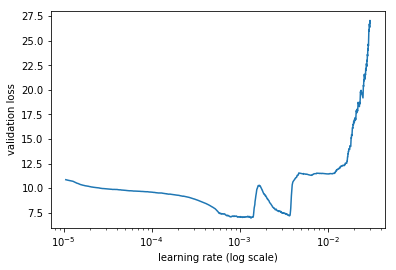

In [28]:
learn.sched.plot()

In [ ]:
#custom callbacks
from tensorboardX import SummaryWriter
from fastai.sgdr import Callback, DecayScheduler
from fastai.learner import Learner

class TensorboardLogger(Callback):
    def __init__(self, path, log_name, metrics_names=[]):
        super().__init__()
        self.metrics_names = ["validation_loss"]
        self.metrics_names += metrics_names
        log_path = os.path.join(path, "logs")
        self.log_dir = os.path.join(log_path, log_name)
        if os.path.exists(self.log_dir): shutil.rmtree(self.log_dir)
        os.makedirs(self.log_dir)
        
    def on_train_begin(self):
        self.iteration = 0
        self.epoch = 0
        self.writer = SummaryWriter(log_dir=self.log_dir)
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics):
        self.epoch += 1
        for val, name in zip(metrics, self.metrics_names):
            self.writer.add_scalar(name, val, self.iteration) 
                        
    def on_phase_end(self): pass
    def on_batch_end(self, loss):
        self.iteration += 1
        self.writer.add_scalar("training_loss", loss, self.iteration)
    def on_train_end(self):
        self.writer.close()
        
        
class BestModelCheckPoint(Callback):
    def __init__(self, learner, path, model_name, lr):
        super().__init__()
        self.learner = learner
        self.model_name = model_name
        self.learning_rate = lr
        self.model_log = {}
        self.model_path = self.learner.models_path
        os.makedirs(self.model_path, exist_ok=True)

    def on_train_begin(self): 
        self.first_epoch = True
        self.epoch = 0
        self.best_loss = 0.

    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): 
        self.epoch += 1
        self.val_loss = metrics[0]
        if self.first_epoch:
            self.best_loss = self.val_loss
            self.first_epoch = False
        elif self.val_loss < self.best_loss:
            self.best_loss = self.val_loss
            self.learner.save(self.model_name)
            self.model_log['training_loss'] = [str(self.train_losses)]
            self.model_log['validation_loss'] = [str(self.val_loss)]
            self.model_log['epoch_num'] = [self.epoch]
            self.model_log['learning_rate'] = [self.learning_rate]
            self.model_log['model_info'] = [w for s in [str(self.learner.model)] for w in s.split('\n')]
            self.model_log['model_info'].append("(attention_type): %s" %self.learner.model.attention_type)
            self.model_log['model_info'].append("(weight_tie): %s" %self.learner.model.tied_weight_type)
            self.model_log['model_info'].append("(pre_trained_vector_type): %s" %self.learner.model.pre_trained_vector_type)
            self.model_log['model_info'].append("(teacher_forcing): %s" %self.learner.model.teacher_forcing)
            if self.learner.model.teacher_forcing: self.model_log['model_info'].append("(teacher_forcing_prob): %s" %self.learner.model.force_prob)
            with open(f'{self.model_path}/{self.model_name}_model_log.json', 'w') as d: json.dump(self.model_log, d)
        else: pass        
    def on_phase_end(self): pass
    def on_batch_end(self, loss):
        self.train_losses = loss
    def on_train_end(self): pass
        

class TeacherForcingSched(Callback):
    def __init__(self, learner, scheduler):
        super().__init__()
        self.learner = learner
        self.scheduler = scheduler
        
    def on_train_begin(self): 
        self.learner.model.force_prob = round(self.scheduler.next_val(),1)
        
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): 
        self.learner.model.force_prob = round(self.scheduler.next_val(),1)
        
    def on_phase_end(self): pass
    def on_batch_end(self, loss):pass
    def on_train_end(self): pass


In [41]:
lr=1e-3
model_name = f'{model.rnn_type}_{model.attention_type}_rev_{rev}'.lower()
cycle_len=15
best_model = BestModelCheckPoint(learn, model_data.path, model_name, lr)
tb_logger = TensorboardLogger(model_data.path, model_name)
sched = DecayScheduler(DecayType.LINEAR, cycle_len, 0.5, 0.0)
teach_forcer = TeacherForcingSched(learn, sched)
learn.fit(lr, 1, cycle_len=cycle_len, use_clr=(20,10), stepper=Seq2SeqStepper, \
          callbacks=[tb_logger, teach_forcer, best_model])

epoch      trn_loss   val_loss                                                           
    0      2.355713   5.541737  
    1      2.546948   5.145187                                                           
    2      2.654558   4.7494                                                             
    3      2.665962   4.443033                                                           
    4      2.717336   4.327981                                                           
    5      2.817562   4.035469                                                           
    6      2.968624   4.194978                                                           
    7      2.948696   4.159783                                                           
    8      3.380821   4.035524                                                           
    9      3.666284   4.078693                                                           
    10     3.895586   4.208393                                     

In [ ]:
import matplotlib.ticker as ticker

In [44]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
    
def generate(x, y, m):
    probs = m.model(V(x))
    preds, attention, encoder_embedding = to_np(probs[0].max(2)[1]), to_np(probs[1].squeeze(1)), to_np(probs[2])
    sentence = ' '.join([index_to_string[o] for o in x[:,0].data.cpu().numpy() if o != 1])
    result = ' '.join([index_to_string[o] for o in preds[:,0] if o!=1])
    orig = ' '.join([index_to_string[o] for o in y[:,0].data.cpu().numpy() if o != 1])
    print('Input: {}'.format(sentence), '\n')
    print('Original summary: {}'.format(orig), '\n')
    print('Predicted summary: {}'.format(result))
    attention_plot = attention[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return preds, attention, encoder_embedding
    

Input: french share prices fell sharply in initial trading on monday . _eos_ 

Original summary: french shares fall sharply _eos_ 

Predicted summary: french shares fall sharply . #


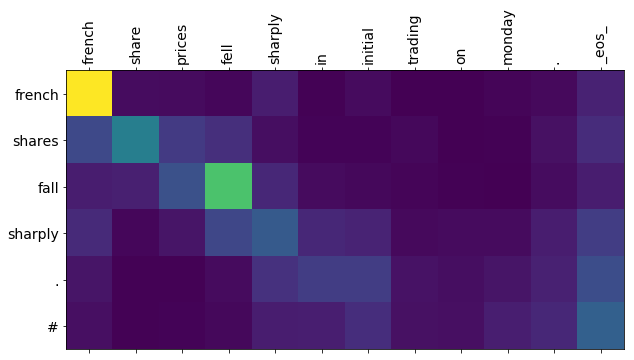

In [52]:
x,y = next(iter(model_data.val_dl))
for i in range(63):
    print(i)
    preds, attention, encoder_embedding = generate(x.transpose(1,0)[i].unsqueeze(1), y.transpose(1,0)[i].unsqueeze(1), learn)
    